In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.applications import * 
from keras.preprocessing.image import * 
from keras.optimizers import * 
from keras.models import *
from keras.layers import * 
img_dim_ordering = "tf"
from keras import backend as K
#K.set_image_dim_ordering(img_dim_ordering)
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import Xception
from tensorflow.keras import initializers

import tensorflow as tf
import torch
from torchvision.models.resnet import *
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn

from PIL import Image
from  PIL import  ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy import ndimage

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from tensorflow.keras.applications import Xception
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/")

Mounted at /content/drive


In [29]:
path = '/content/drive/MyDrive/AI final'
train_data_dir = "/content/drive/MyDrive/AI final/train/"
val_data_dir = "/content/drive/MyDrive/AI final/validate/"
test_data_dir = "/content/drive/MyDrive/AI final/test/"

In [53]:
labels ={   '0' : 'titi',
            '1' : 'squirrel',
            '2' : 'spider',
            '3' : 'probocis',
            '4' : 'hussar',
            '5' : 'howler',
            '6' : 'guenon',
            '7' : 'gorilla',
            '8' : 'gibbon',
            '9' : 'colobus',
            '10': 'chimpanzee' }

In [31]:
# Load the paths to the images in a directory

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            
            if img is not None:
                end=filename.find(".")
                file_name.append(file[0:end])
                images.append(img)
                
        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path


In [32]:
# Load the paths on the images
import os, os.path
images = []
path = train_data_dir
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
    else: 
        images += load_images_from_folder(path+f,True,label = f)
        
                        
# Create a dataframe with the paths and the label for each monkey species
train_df = pd.DataFrame(images, columns = ["monkey_id", "path_img"])

In [33]:
monkey_label=[]
train_len=len(train_df["path_img"])
for i in range(train_len):
    temp = train_df.monkey_id[i]
    
    monkey_label.append(temp)

train_df['monkey_label'] = monkey_label
train_df

,monkey_id,path_img,monkey_label
0,spider,/content/drive/MyDrive/AI final/train/spider/s...,spider
1,spider,/content/drive/MyDrive/AI final/train/spider/s...,spider
2,spider,/content/drive/MyDrive/AI final/train/spider/s...,spider
3,spider,/content/drive/MyDrive/AI final/train/spider/s...,spider
4,spider,/content/drive/MyDrive/AI final/train/spider/s...,spider
...,...,...,...
8826,chimpanzee,/content/drive/MyDrive/AI final/train/chimpanz...,chimpanzee
8827,chimpanzee,/content/drive/MyDrive/AI final/train/chimpanz...,chimpanzee
8828,chimpanzee,/content/drive/MyDrive/AI final/train/chimpanz...,chimpanzee
8829,chimpanzee,/content/drive/MyDrive/AI final/train/chimpanz...,chimpanzee


In [34]:
images = []
path = val_data_dir
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
      
    else: 
        images += load_images_from_folder(path+f,True,label = f)
            
            
                        
# Create a dataframe with the paths and the label for each monkey species
val_df = pd.DataFrame(images, columns = ["monkey_id", "path_img"])

In [35]:
val_df

,monkey_id,path_img
0,squirrel,/content/drive/MyDrive/AI final/validate/squir...
1,squirrel,/content/drive/MyDrive/AI final/validate/squir...
2,squirrel,/content/drive/MyDrive/AI final/validate/squir...
3,squirrel,/content/drive/MyDrive/AI final/validate/squir...
4,squirrel,/content/drive/MyDrive/AI final/validate/squir...
...,...,...
1109,chimpanzee,/content/drive/MyDrive/AI final/validate/chimp...
1110,chimpanzee,/content/drive/MyDrive/AI final/validate/chimp...
1111,chimpanzee,/content/drive/MyDrive/AI final/validate/chimp...
1112,chimpanzee,/content/drive/MyDrive/AI final/validate/chimp...


In [36]:
train_df["monkey_id"].value_counts(ascending=False)

guenon        811
proboscis     806
hussar        805
titi          804
howler        803
chimpanzee    802
spider        800
squirrel      800
colobus       800
gibbon        800
gorilla       800
Name: monkey_id, dtype: int64

In [38]:
test_data_dir = "/content/drive/MyDrive/AI final/test/"

In [39]:
img_width, img_height = 299,299
batch_size = 256
classes = 11

#prepare data augmentation configuration
train_datagen = ImageDataGenerator(
                rescale=1. / 255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

valid_datagen = ImageDataGenerator(
                rescale=1. / 255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator(
                rescale=1. / 255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                  train_data_dir,
                  target_size=(img_height, img_width),
                  batch_size = batch_size,
                  class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
                  val_data_dir,
                  target_size=(img_height, img_width),
                  batch_size = batch_size,
                  class_mode='categorical')

test_generator =  test_datagen.flow_from_directory(
                  test_data_dir,
                  shuffle = False,
                  target_size=(img_height, img_width),
                  batch_size = batch_size,
                  class_mode='categorical')

Found 8829 images belonging to 11 classes.
Found 1113 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


Instantiate a tensor input (define images input for the pretrained model).

In [40]:
input_tensor = Input(shape=(img_width,img_height,3))

Stop training when a monitored metric (I chose accuracy metric in this case) has stopped improving with patience=2.

In [41]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

Define the Optimizers and Learning rate

In [42]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6,momentum=0.9,nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Xception is a convolutional neural network that is 71 layers deep. (This network has an image input size of 299-by-299.) We can load a pre-trained version of the network trained on more than a million images from the ImageNet database. The pre-trained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. 

I also add the sequential model (top_model) with four layers on top of the pretrained model (input model) before the output of the model to define the desire output model. Such as Flattens the input, Dropout some pictures to prevent overfitting, BatchNormalization that maintains the mean output close to 0 and the output standard deviation close to 1, and Dense layer 11 classes with softmax activation function.

In [43]:
pretrained_model = Xception(weights='imagenet',include_top=False,input_tensor=input_tensor)
for layer in pretrained_model.layers:
    layer.trainable = False

top_model = Sequential()
top_model.add(Flatten(input_shape=pretrained_model.output_shape[1:]))
top_model.add(Dropout(0.3))
top_model.add(BatchNormalization())
top_model.add(Dense(classes, activation='softmax'))


outputs = top_model(pretrained_model.output)
model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

83697664/83683744 [==============================] - 1s 0us/step


In [44]:
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [45]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout (Dropout)           (None, 204800)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 204800)           819200    
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 11)                2252811   
                                                                 
Total params: 3,072,011
Trainable params: 2,662,411
Non-trainable params: 409,600
_________________________________________________________________


Callback to save my model at its greatest performing frequency (I'm seeking for the highest validate accuracy).

In [47]:
checkpointer = ModelCheckpoint(filepath =  "/work/my_model.h5",
                               monitor='val_accuracy', 
                               verbose=1, 
                               save_best_only=True, 
                               mode='max'
                               )

In [48]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch= 8829 // batch_size,
    epochs = 5,
    validation_data=valid_generator,
    validation_steps = 1113// batch_size,
    callbacks = [checkpointer,earlyStoppingCallback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
28/34 [=======================>......] - ETA: 8:57 - loss: 0.3792 - accuracy: 0.8997 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34/34 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.9077  
Epoch 00001: val_accuracy improved from -inf to 0.95117, saving model to /work/my_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


34/34 [==============================] - 3559s 104s/step - loss: 0.3488 - accuracy: 0.9077 - val_loss: 0.1594 - val_accuracy: 0.9512
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9544  
Epoch 00002: val_accuracy did not improve from 0.95117
34/34 [==============================] - 3102s 92s/step - loss: 0.1756 - accuracy: 0.9544 - val_loss: 0.1575 - val_accuracy: 0.9512
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9634  
Epoch 00003: val_accuracy did not improve from 0.95117
34/34 [==============================] - 3239s 96s/step - loss: 0.1354 - accuracy: 0.9634 - val_loss: 0.1472 - val_accuracy: 0.9502
Epoch 4/5
34/34 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9689  
Epoch 00004: val_accuracy improved from 0.95117 to 0.95312, saving model to /work/my_model.h5
34/34 [==============================] - 2928s 87s/step - loss: 0.1107 - accuracy: 0.9689 - val_loss: 0.1849 - val

I think this can go further with more epoch than this but I use only five epochs because it take a lot of time and some memory(ram) on the runtime.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


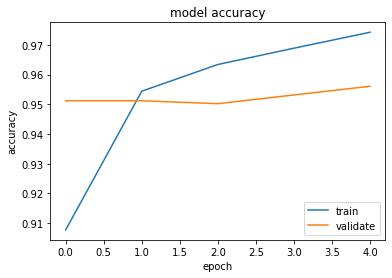

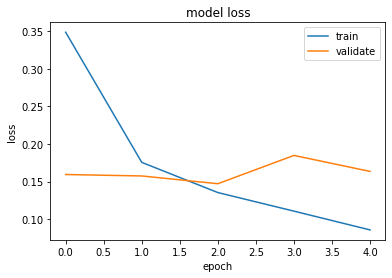

In [49]:
print(history.history.keys())

# summarize the history of accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc ='lower right')
plt.show()

# summarize the history of loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [50]:
# Predict the label of the test_data
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
label = (train_generator.class_indices)
label = dict((v,k) for k,v in labels.items())

In my prediction result, map the labels.

In [54]:
pred = [labels[str(k)] for k in pred]

In [55]:
pred

['titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirre

To calculate the accuracy with the prediction result, map the labels in the test dataset.

In [56]:
test_label = [labels[str(k)] for k in test_generator.classes]

In [57]:
test_label

['titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'titi',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirrel',
 'squirre

For certainty, I've tried to calculate the accuracy on the test set using two methods: accuracy_score(test_label, pred) and model.evaluate(test_generator).

In [66]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_label, pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 98.36%


In [63]:
score = model.evaluate(test_generator)
score

5/5 [==============================] - 124s 23s/step - loss: 0.0734 - accuracy: 0.9845


[0.07343753427267075, 0.9845454692840576]

In [64]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.07343753427267075
Test accuracy: 0.9845454692840576


### Visualize the result

In [59]:
from sklearn.metrics import classification_report
class_report = classification_report(test_label, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

  chimpanzee       1.00      0.96      0.98       100
     colobus       1.00      1.00      1.00       100
      gibbon       0.99      0.97      0.98       100
     gorilla       1.00      1.00      1.00       100
      guenon       1.00      0.99      0.99       100
      howler       0.96      0.96      0.96       100
      hussar       0.95      0.99      0.97       100
    probocis       1.00      0.99      0.99       100
      spider       0.94      0.98      0.96       100
    squirrel       0.98      0.98      0.98       100
        titi       1.00      1.00      1.00       100

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100



### Examples of prediction

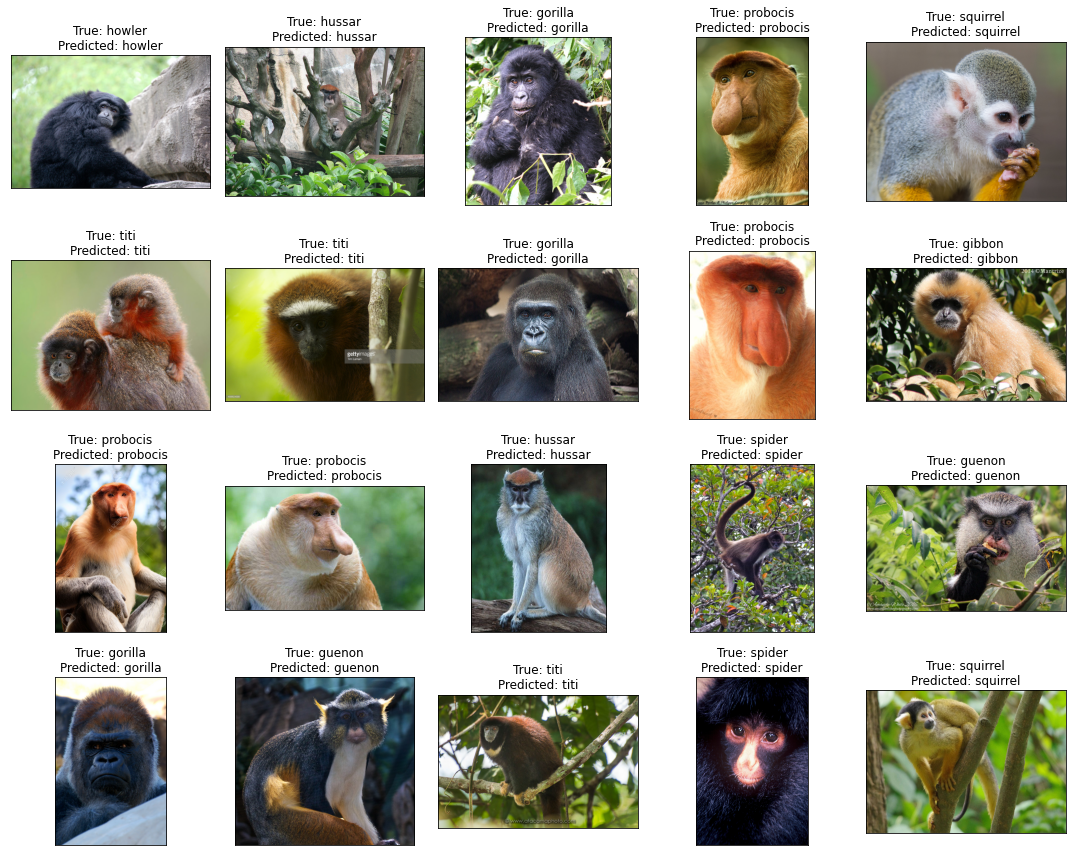

In [174]:
# Display 20 pictures of the dataset with their labels
import random
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    j=random.randint(0,1000)
    ax.imshow(plt.imread(test_generator.filepaths[len(test_generator.filepaths)-j]))
    ax.set_title(f"True: {test_label[j]}\nPredicted: {pred[j].split('_')[0]}")
plt.tight_layout()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e8bed41e-d597-4cde-bf4f-4e370a848d62' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>